In [1]:
from src.utils import IoU
from src.dataloaders.brats import BRATS
from src.dataloaders.elastic_trans import BRATS as EL_BRATS
from src.models.unet import UNet
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import skimage.filters

def entropy_pixelwise(image):
    entropy_image = np.zeros_like(image, dtype=float)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            p = image[i, j]
            if p == 0 or p == 1:
                entropy_val = 0.0
            else:
                entropy_val = -p * np.log2(p) - (1 - p) * np.log2(1 - p)
                # print(p*100000, entropy_val*100000)
            entropy_image[i, j] = entropy_val
    return entropy_image

def std_pixelwise(image, neighborhood_size=3):
    padded_image = np.pad(image, (neighborhood_size//2, neighborhood_size//2), mode='constant')
    std_dev_image = np.zeros_like(image, dtype=np.float32)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            neighborhood = padded_image[i:i+neighborhood_size, j:j+neighborhood_size]
            std_dev_image[i, j] = np.std(neighborhood)
    return std_dev_image

def mean_pixelwise(image, mask_size=3):
    mask = np.ones((mask_size, mask_size)) / mask_size*mask_size
    padded_image = np.pad(image, ((1, 1), (1, 1)), mode='edge')
    mean_values = np.zeros_like(image, dtype=float)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            neighborhood = padded_image[i:i+3, j:j+3]
            val = np.sum(neighborhood * mask)
            mean_values[i, j] = val
    return mean_values

def is_binary_image(image_array):
#   len(np.unique(image_array)) <= 2
    unique_values = np.unique(image_array)
    if len(unique_values) <= 2:
        return True
    else:
        return False

def get_binary_entropy(image):
    flat_image = image.flatten()
    p = np.mean(flat_image)
    if p == 0 or p == 1:
        entropy_val = 0.0
    else:
        entropy_val = -p * np.log2(p) - (1 - p) * np.log2(1 - p)
    return entropy_val

# def get_entropy(image):
#     hist, _ = np.histogram(image, bins=[0, 1, 2])     # Compute histogram of intensity values (0 and 1)
#     probs = hist / np.sum(hist)     # Normalize histogram to get probability distribution
#     entropy = -np.sum(probs * np.log2(probs + 1e-10))  # Add a small value to avoid log(0)
#     return entropy

def get_entropy(image):
    flat_image = image.flatten()
    p = np.mean(flat_image)
    if p == 0 or p == 1:
        entropy_val = 0.0
    else:
        entropy_val = -p * np.log2(p) - (1 - p) * np.log2(1 - p)
    return entropy_val

def get_std(image):
    return np.std(image)

def get_mean(image):
    return np.mean(image)


In [2]:
dataloaders = []
hgg_set = BRATS('../../../../special-course/data/MICCAI_BraTS_2018_Data_Training', mode='test-hgg', subset=0.6, size=[64, 64, 155])
# hgg_set = BRATS('../../../../special-course/data/MICCAI_BraTS_2018_Data_Training', mode='train-hgg', subset=0.6, size=[64, 64, 155])
hgg_dataloader = torch.utils.data.DataLoader(hgg_set, batch_size=16, shuffle=False, drop_last=False)
dataloaders.append(hgg_dataloader)
lgg_set = BRATS('../../../../special-course/data/MICCAI_BraTS_2018_Data_Training', mode='test-lgg', subset=0.6, size=[64, 64, 155])
# lgg_set = BRATS('../../../../special-course/data/MICCAI_BraTS_2018_Data_Training', mode='train-lgg', subset=0.6, size=[64, 64, 155])
lgg_dataloader = torch.utils.data.DataLoader(lgg_set, batch_size=16, shuffle=False, drop_last=False)
dataloaders.append(lgg_dataloader)

# path = "../../../results/res-fanciful-disco-117/" # ensemble 10 - early stop 20
path = "../../../results/res-jolly-morning-122/" # dropout ensemble 10 - early stop 20

models = [file for file in os.listdir(path) if file.endswith('.pth')]
models = sorted(models)
print('Amount of models:', len(models), ' Amount of validation images:', len(hgg_dataloader), len(lgg_dataloader))


Amount of models: 10  Amount of validation images: 611 223


In [3]:
model = UNet('test-iou')
model.load_state_dict(torch.load(path + models[9]))

<All keys matched successfully>

65 0 hgg


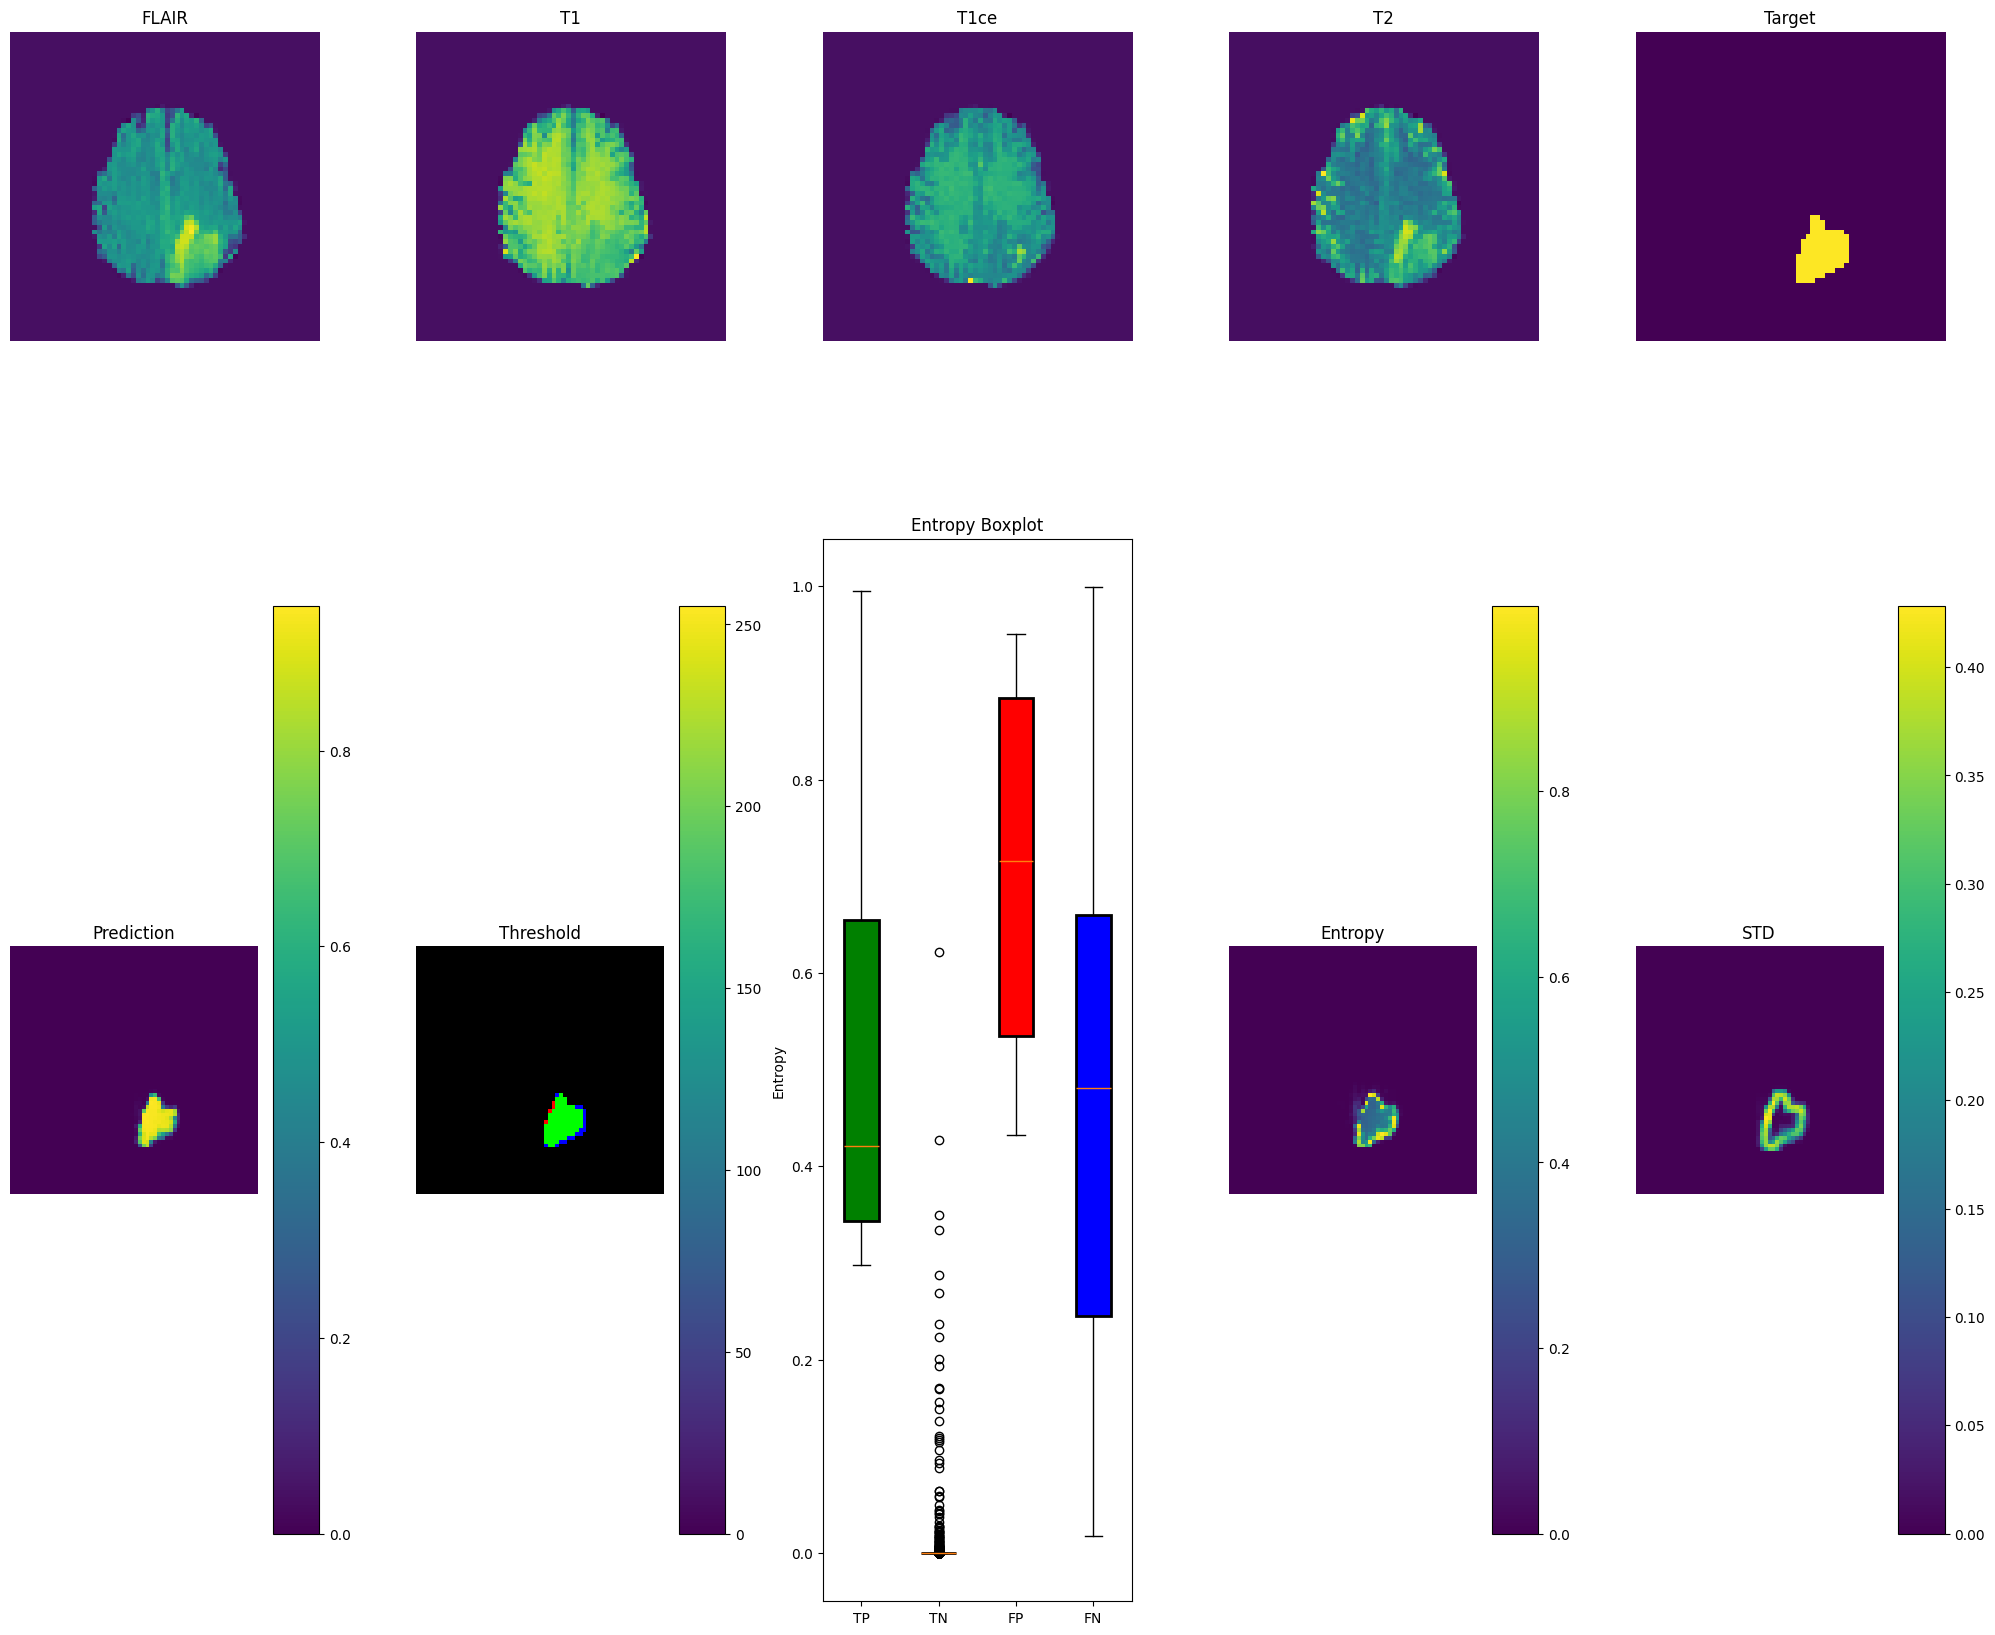

228 0 hgg


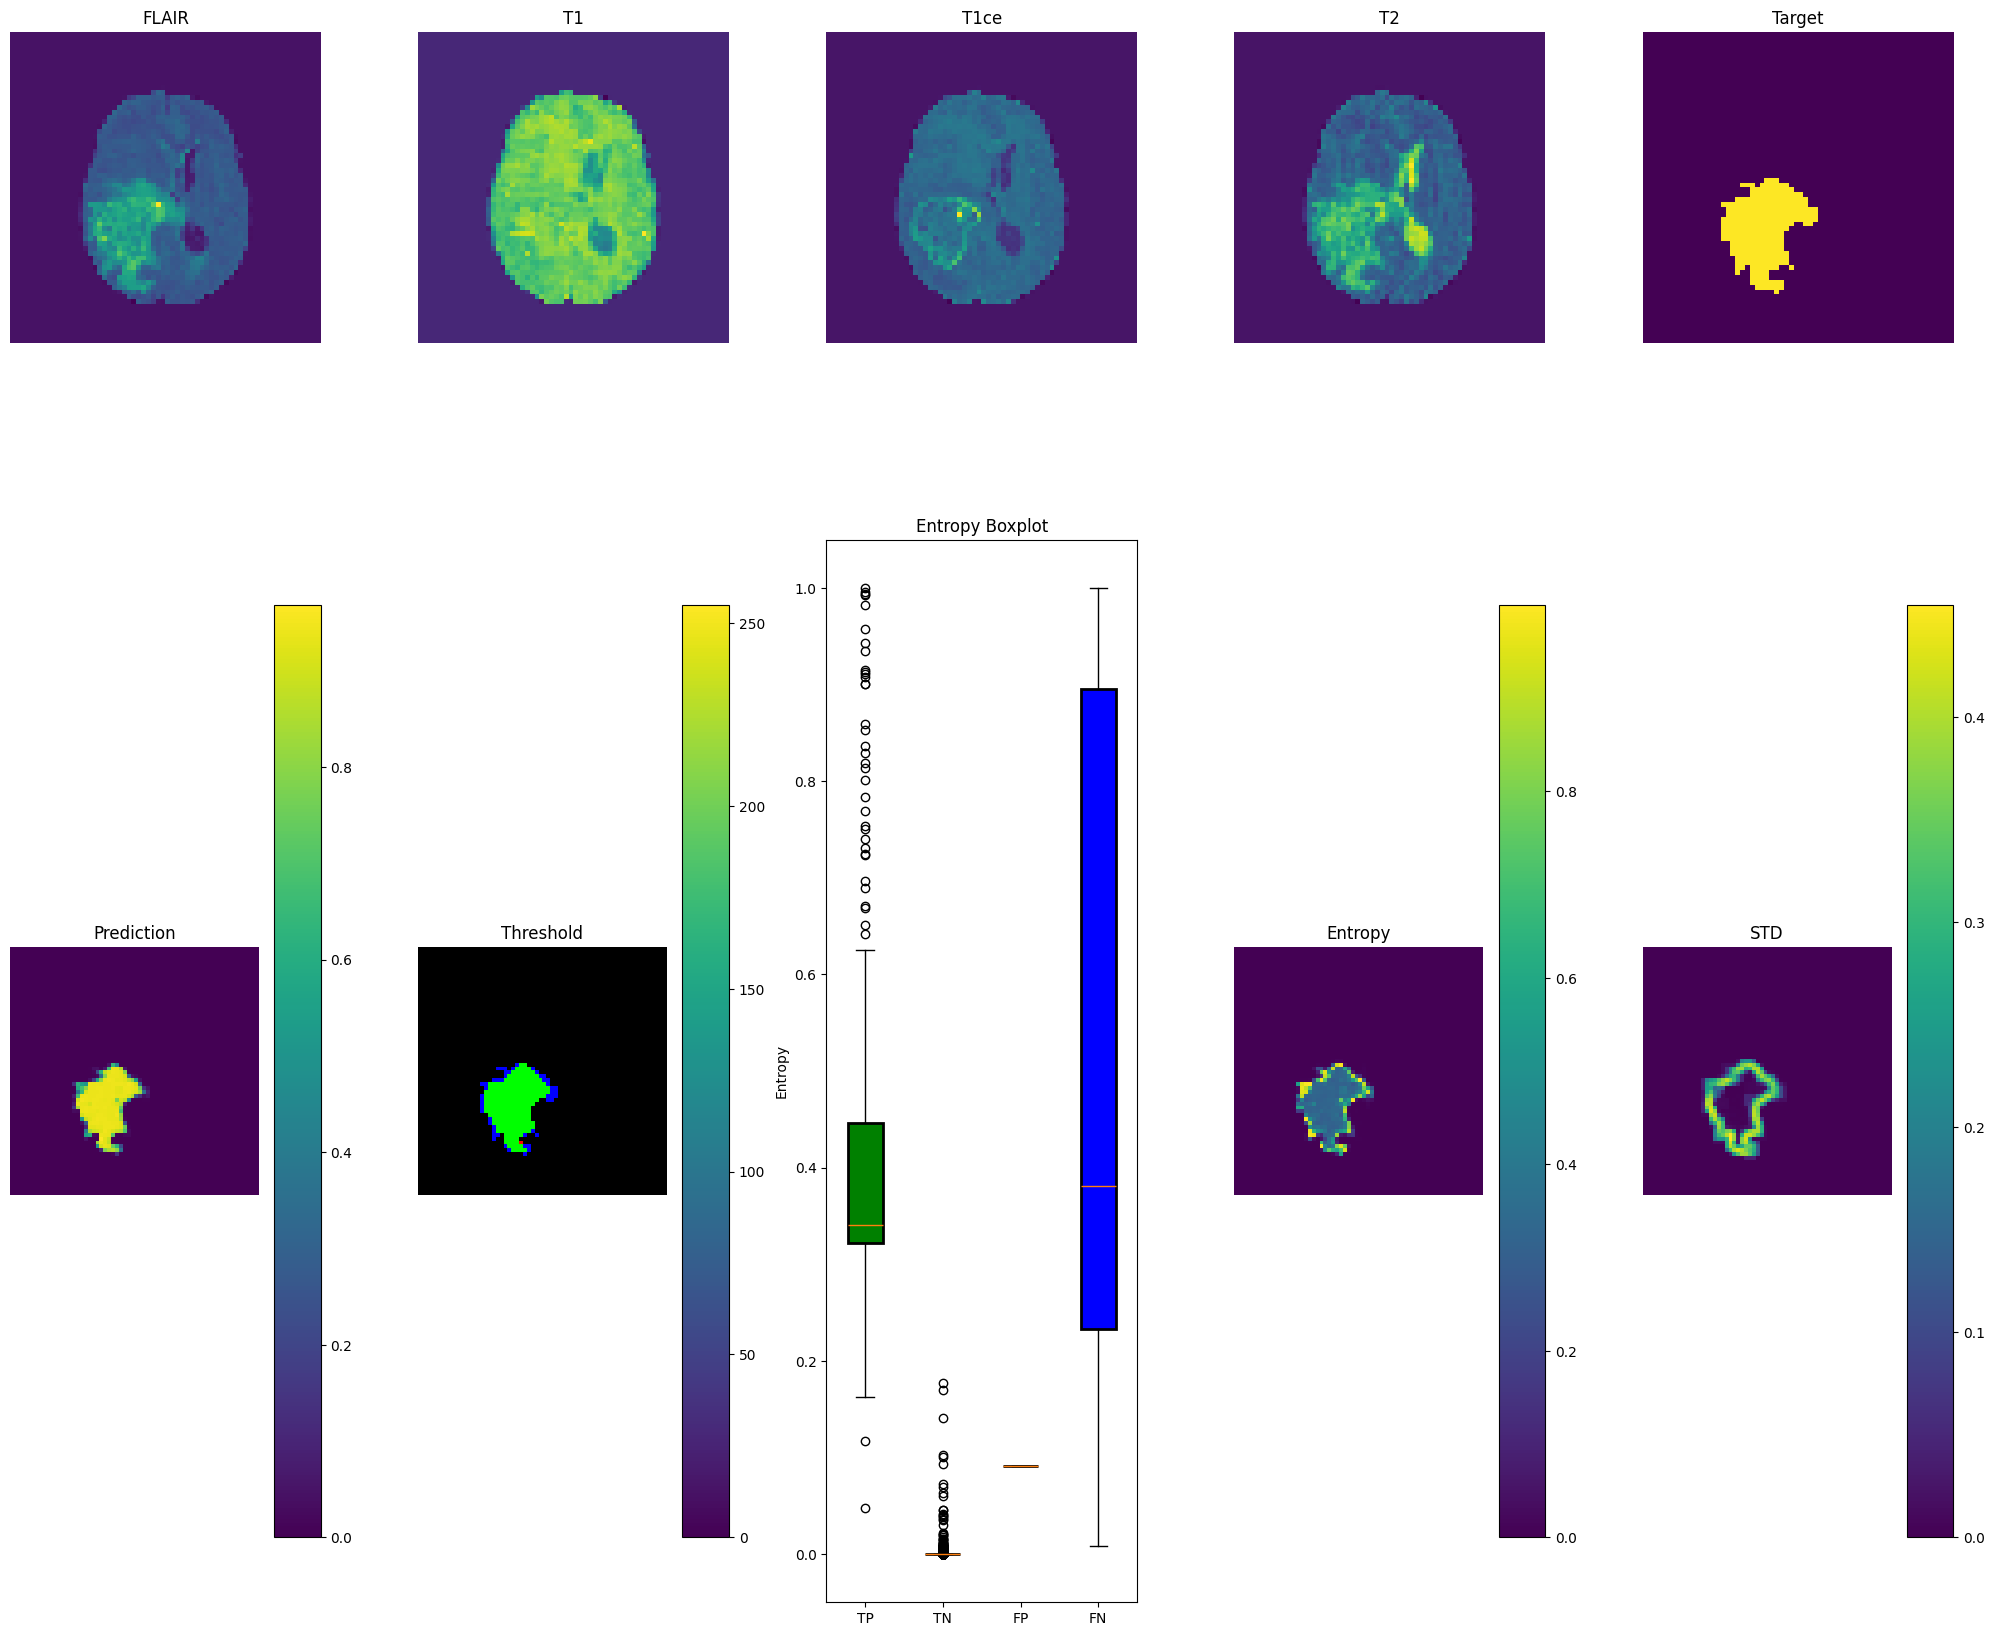

383 0 hgg


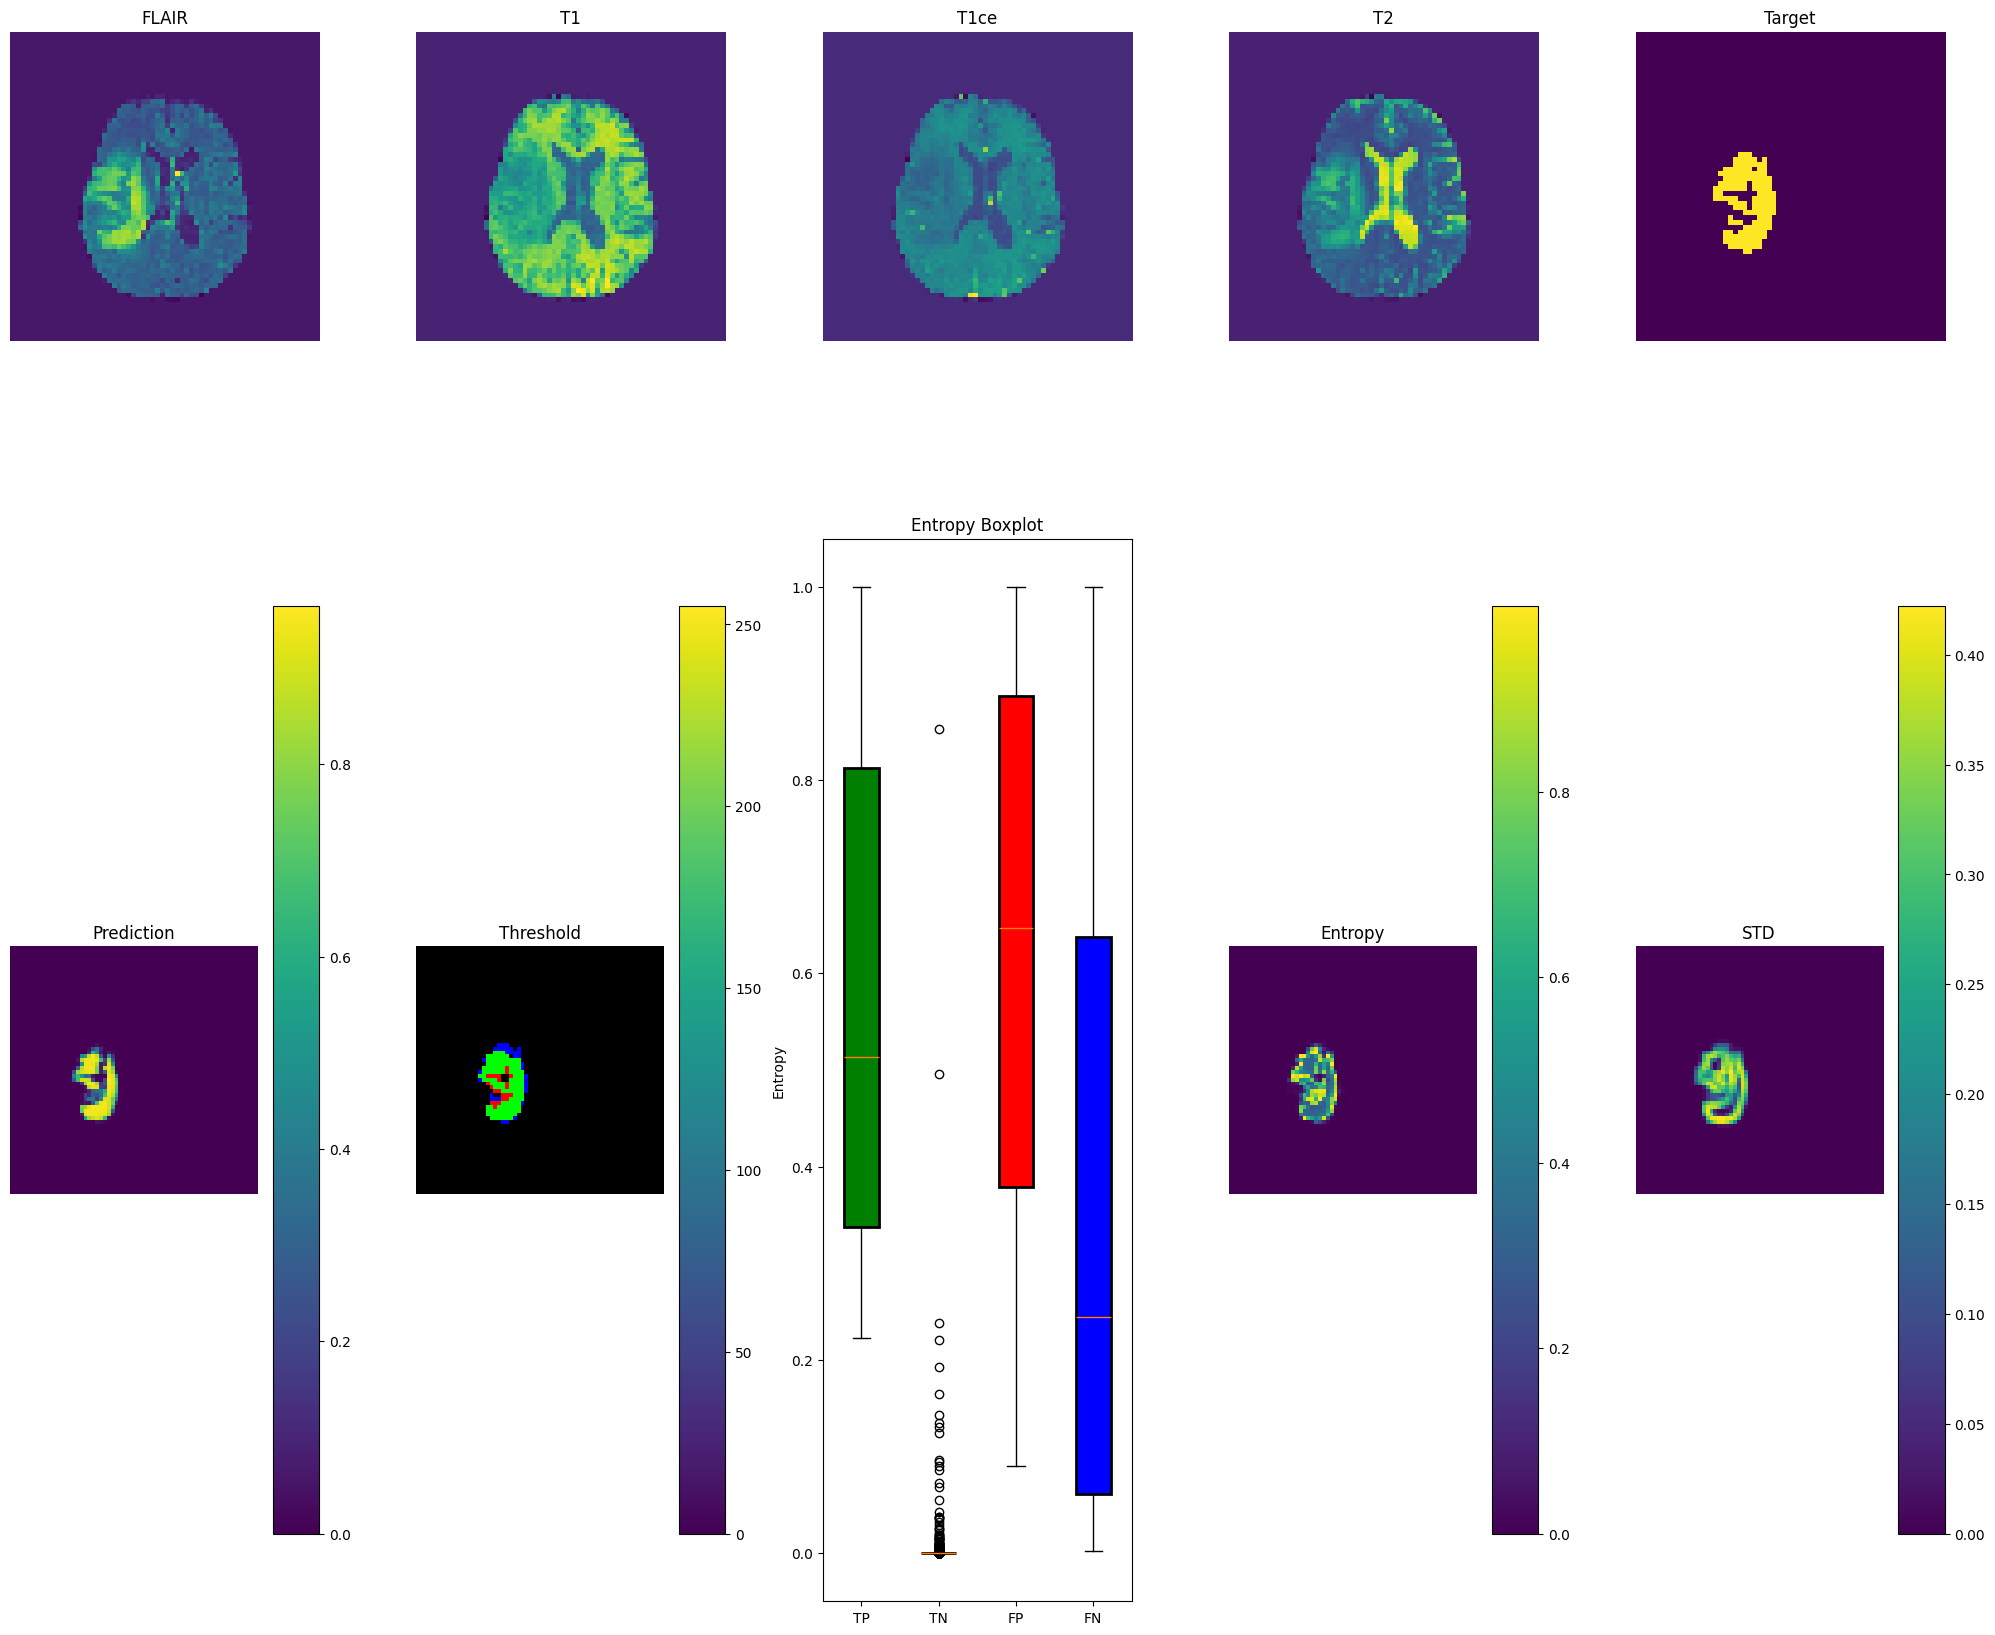

0 ent 3 0 0
139 1 lgg


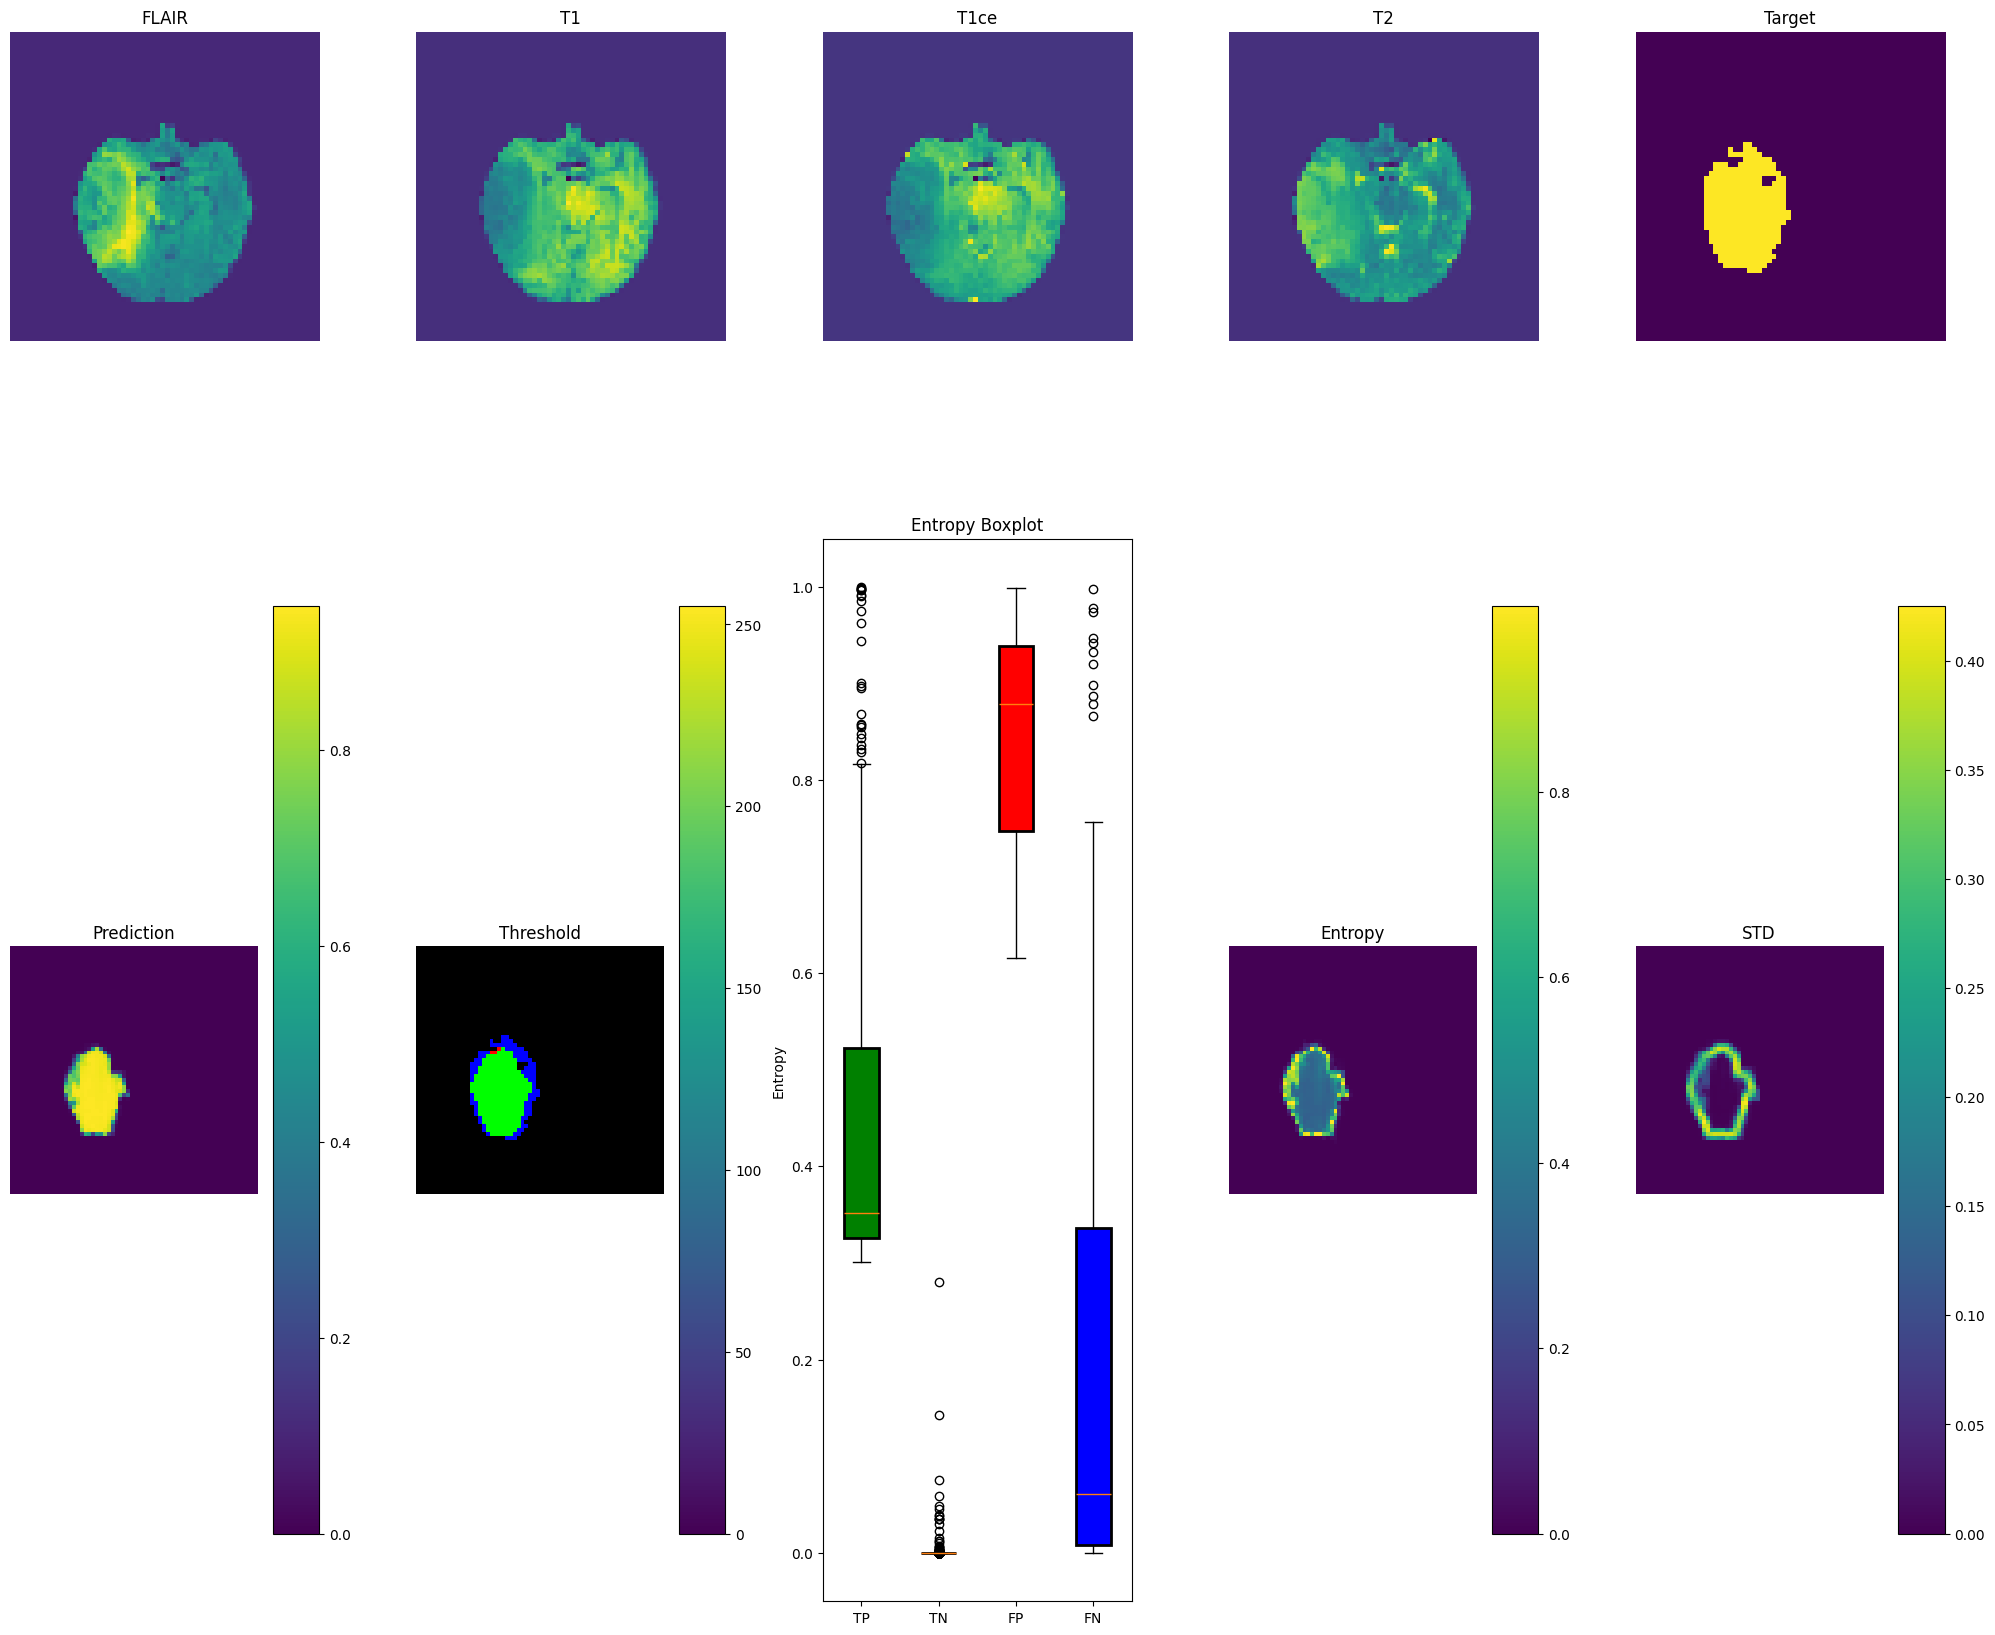

170 1 lgg


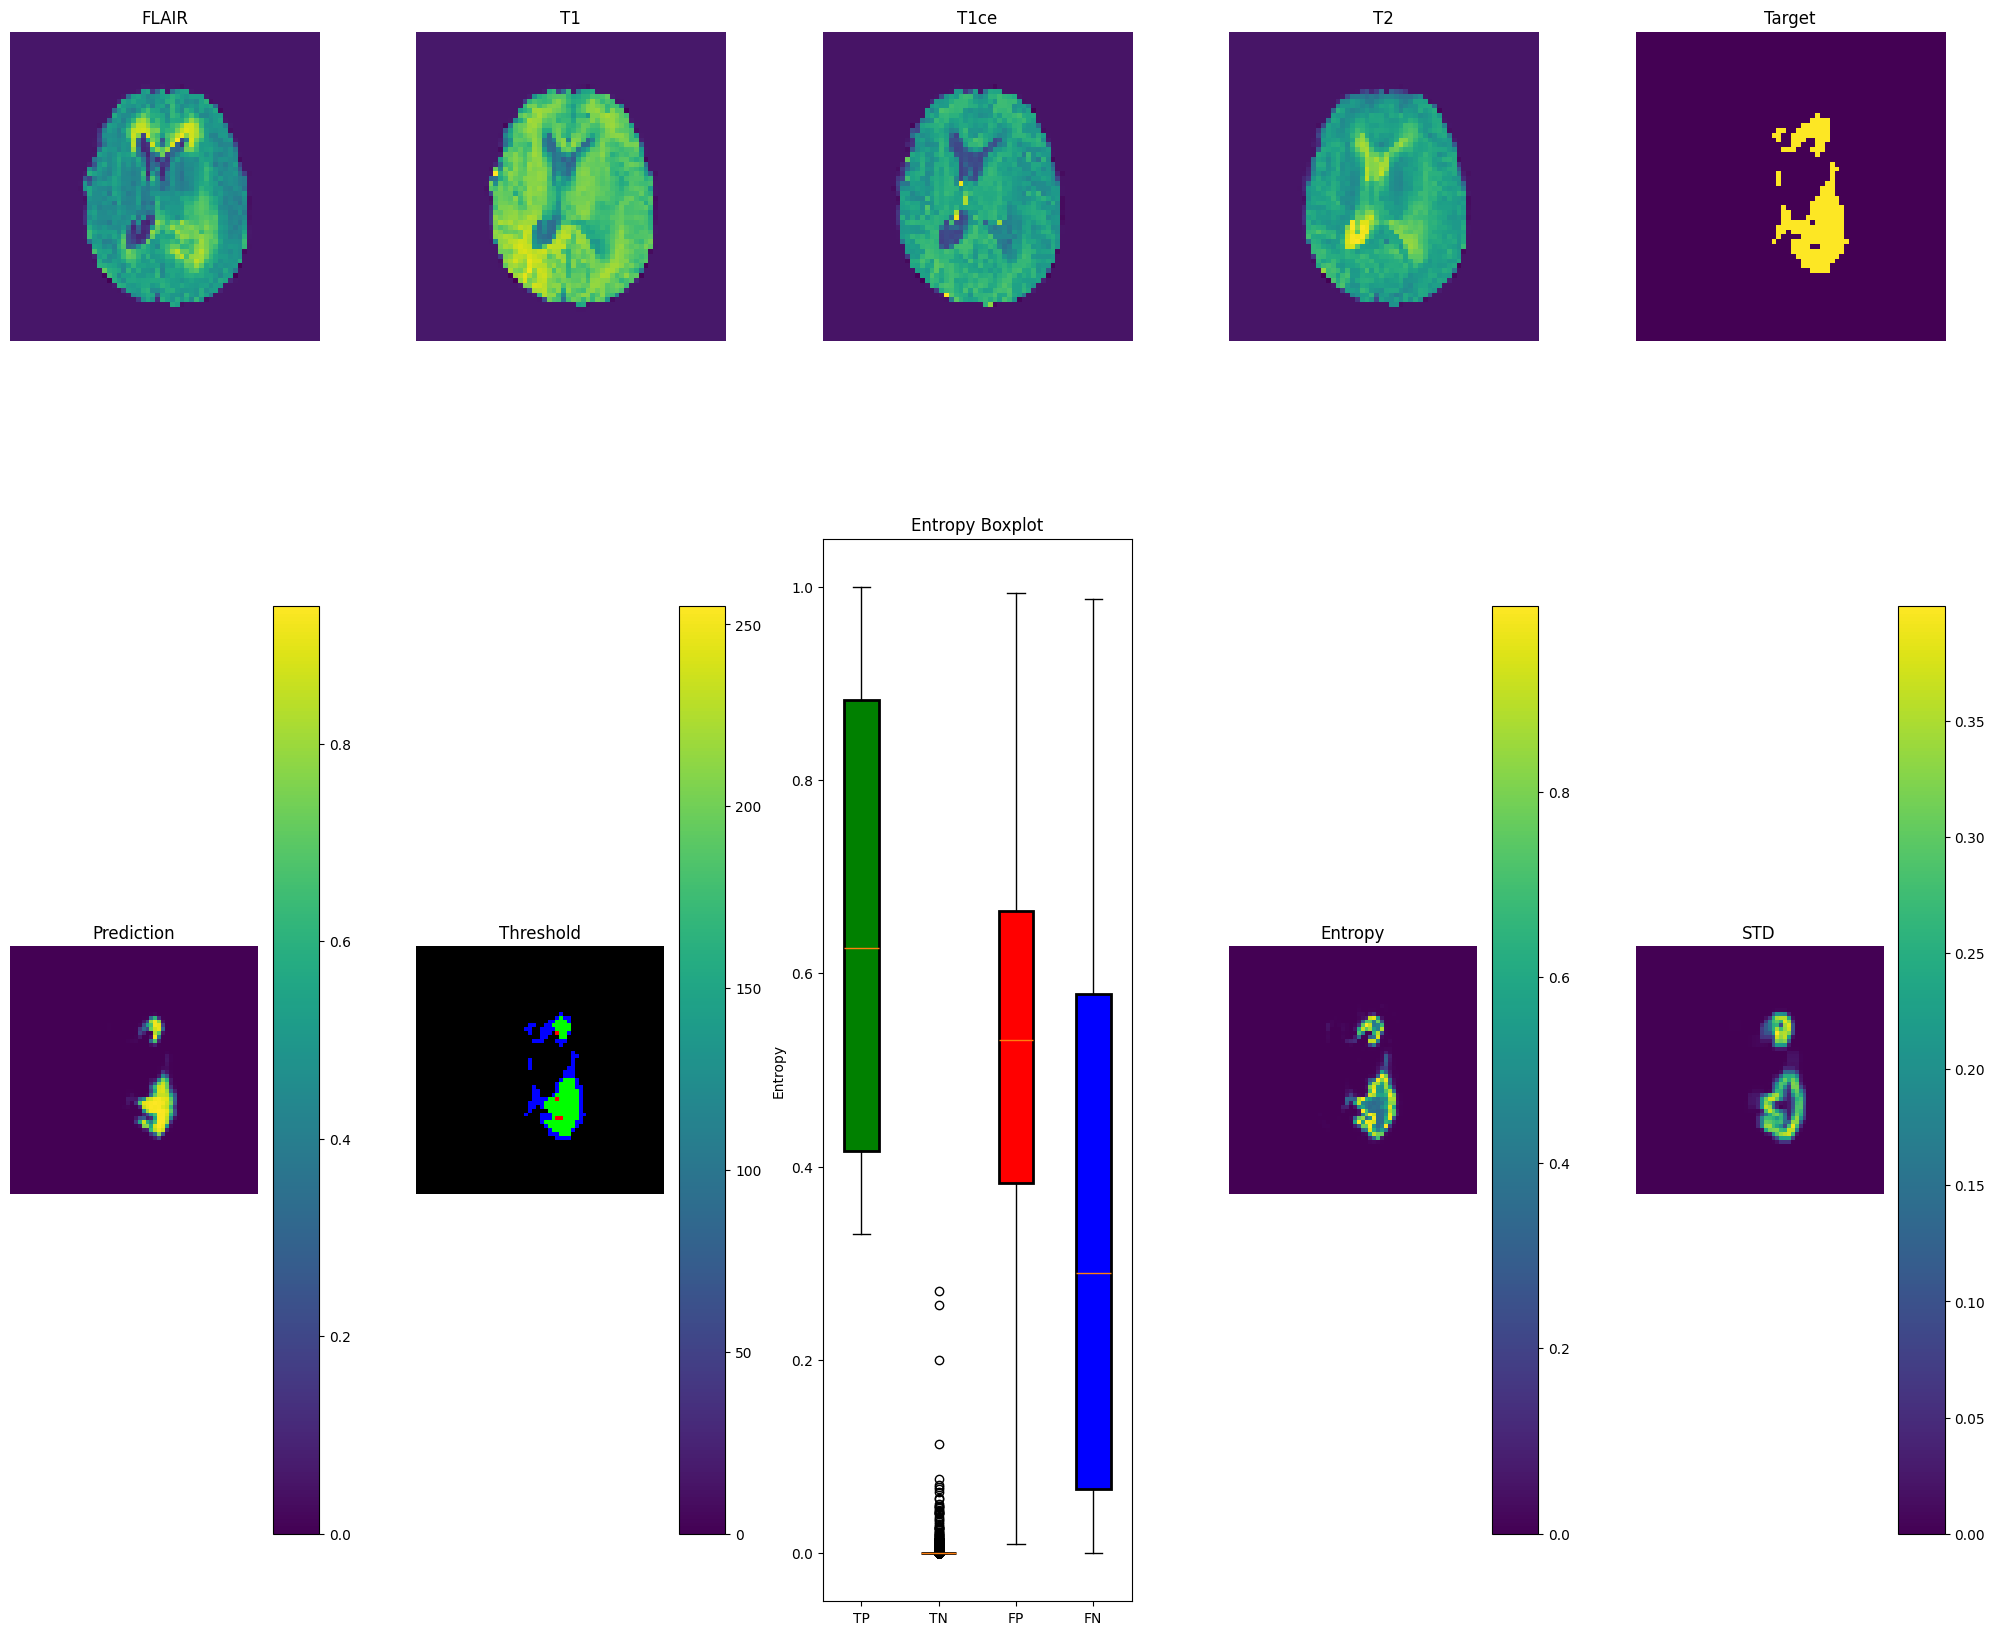

196 1 lgg


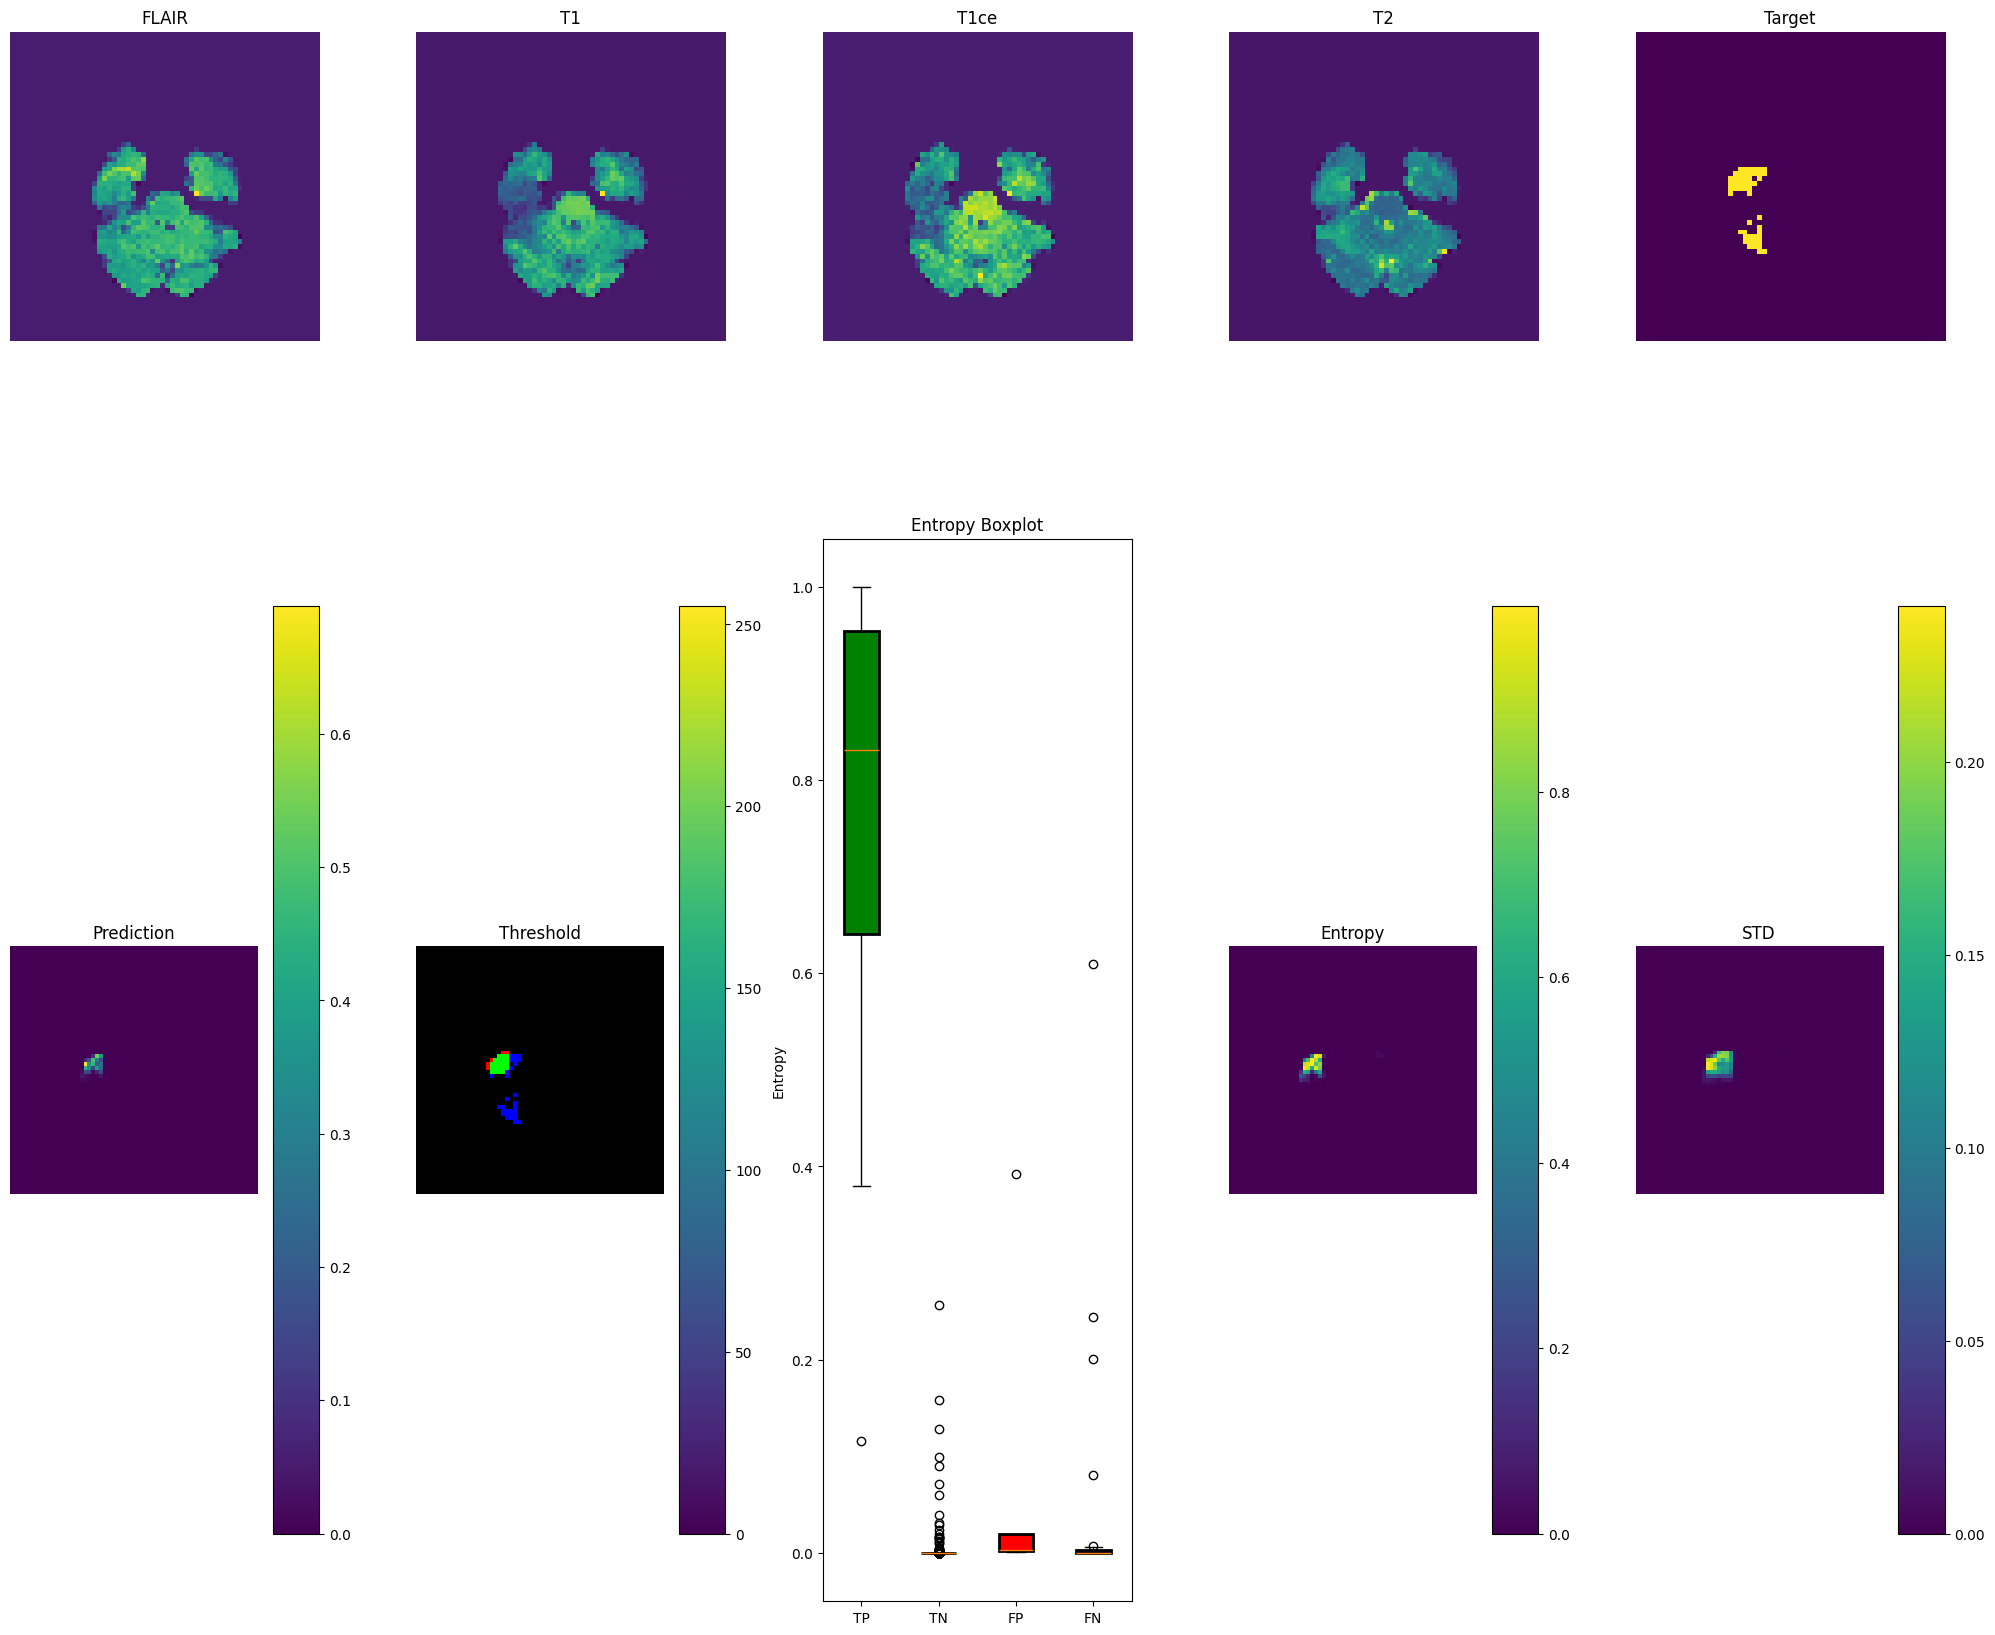

1 ent 3 3 0


In [4]:
ious = []
ious_all = []

losses = []
losses_all = []

means_hgg = []
means_lgg = []
means_empty = []

entropies_hgg = []
entropies_lgg = []
entropies_empty = []

stds_hgg = []
stds_lgg = []
stds_empty = []

empty_counter = 0

color_map = {
    (0, 255, 0): 'TP',
    (255, 0, 0): 'FP',
    (0, 0, 0): 'TN',
    (0, 0, 255): 'FN'
}

thres_arr = []


for i in range(len(dataloaders)):
    pos_weight = 0.0103 if i == 0 else 0.0074
    for index, (inputs, targets, _) in enumerate(dataloaders[i]):
        if not ((i == 0 and (index==65 or index== 228 or index == 383)) or (i == 1 and (index == 139 or index == 170 or index == 196))):
            continue
        train_iou = 0.0
        train_loss = 0.0
        train_entropy = 0.0
        train_std = 0.0
        train_mean = 0.0
        iou_arr = []
        loss_arr = []
        ent_arr = []
        std_arr = []
        mean_arr = []
        np_img = inputs.detach().numpy()

        np_target = targets.detach().numpy()
        logits = model(inputs)
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))

        loss = criterion(logits, targets)
        train_loss += float(loss)
        loss_arr.append(float(loss))

        np_pred = torch.sigmoid(logits.detach()).numpy()
        np_pred = np_pred[0, 0, :, :]

        entropy = get_binary_entropy(np_pred)
        train_entropy += entropy
        ent_arr.append(entropy)

        std = np.std(np_pred)
        train_std += std
        std_arr.append(std)

        mean = np.mean(np_pred)
        train_mean += mean
        mean_arr.append(mean)

        iou = float(IoU(targets.detach(), torch.sigmoid(logits.detach()).ge(0.5)))
        train_iou += iou
        iou_arr.append(iou)

        if np_target.sum() == 0.0:
            ious.append(np.NAN)
            losses.append(np.NAN)
            ious_all.append(np.mean(iou_arr))
            losses_all.append(np.mean(loss_arr))
            empty_counter += 1
        elif i == 0:
            ious.append(np.mean(iou_arr))
            losses.append(np.mean(loss_arr))
            ious_all.append(np.mean(iou_arr))
            losses_all.append(np.mean(loss_arr))
        elif i == 1:
            ious.append(np.mean(iou_arr))
            losses.append(np.mean(loss_arr))
            ious_all.append(np.mean(iou_arr))
            losses_all.append(np.mean(loss_arr))

        # CODE FOR VISUALISATION - IMAGE - TARGET - MEAN OF 10 PRED (XX) - STD OF 10 PRED - ENTROPY OF (XX)
        cur_mean = mean_pixelwise(np_pred)
        thres = skimage.filters.threshold_otsu(cur_mean)
        thres_arr.append(thres)
        cur_pred = (cur_mean > thres).astype(np.uint8)  # Or np.bool_ for boolean array
        cur_std = std_pixelwise(np_pred)
        # cur_entropy = entropy_pixelwise(cur_mean)
        cur_entropy = entropy_pixelwise(np_pred)

        if np_target.sum() == 0.0:
            entropies_empty.append(np.mean(cur_entropy))
            means_empty.append(np.mean(cur_mean))
            print(index, i, 'empty')
        elif i == 0:
            entropies_hgg.append(np.mean(cur_entropy))
            means_hgg.append(np.mean(cur_mean))
            print(index, i, 'hgg')
        elif i == 1:
            entropies_lgg.append(np.mean(cur_entropy))
            means_lgg.append(np.mean(cur_mean))
            print(index, i, 'lgg')


        # test
        # if np_target.sum() > 1000:# and (index == 43 or index == 83):
        # if ((i == 0 and (index==25 or index==65 or index==138 or index==208 or index==218 or index==228 or index==324 or index==383)) or
        #     (i == 1 and (index == 74 or index == 139 or index == 151 or index == 160 or index == 170 or index == 196 or index == 211))):
        # if ((i == 0 and index==383) or (i == 1 and index == 139)):
        if ((i == 0 and (index==65 or index==228 or index == 383)) or (i == 1 and (index == 139 or index == 170 or index == 196))):
        # train
        # if np_target.sum() > 1000 and (index == 44 or index == 218):
            fig, axes = plt.subplots(2, 5, figsize=(20,20))

            # im1 = axes[0].imshow(np_target[0, 0, :, :])
            # axes[0].set_title('Target')
            # axes[0].axis('off')
            # fig.colorbar(im1, ax=axes[0])
            #
            # im2 = axes[1].imshow(cur_mean)
            # axes[1].set_title("Mean")
            # axes[1].axis('off')
            # fig.colorbar(im2, ax=axes[1])
            #
            # im3 = axes[2].imshow(cur_std)
            # axes[2].imshow(cur_std)
            # axes[2].set_title("STD")
            # axes[2].axis('off')
            # fig.colorbar(im3, ax=axes[2])
            #
            # im4 = axes[3].imshow(cur_entropy)
            # axes[3].imshow(cur_entropy)
            # axes[3].set_title("Entropy")
            # axes[3].axis('off')
            # fig.colorbar(im4, ax=axes[3])

            axes[0][0].imshow(np_img[0, 0, :, :])
            axes[0][0].set_title('FLAIR')
            axes[0][0].axis('off')

            axes[0][1].imshow(np_img[0, 1, :, :])
            axes[0][1].set_title('T1')
            axes[0][1].axis('off')

            axes[0][2].imshow(np_img[0, 2, :, :])
            axes[0][2].set_title('T1ce')
            axes[0][2].axis('off')

            axes[0][3].imshow(np_img[0, 3, :, :])
            axes[0][3].set_title('T2')
            axes[0][3].axis('off')

            np_target = np_target[0, 0, :, :]
            im1 = axes[0][4].imshow(np_target)
            # axes[4].imshow(np_target[0, 0, :, :])#, cmap='binary')
            axes[0][4].set_title('Target')
            axes[0][4].axis('off')
            # fig.colorbar(im1, ax=axes[0][4])

            combined_image = np.zeros((64, 64, 3), dtype=np.uint8)
            combined_image[(np_target == 1) & (cur_pred == 1)] = [0, 255, 0] # tp - green
            combined_image[(np_target == 0) & (cur_pred == 1)] = [255, 0, 0] # fp - red
            combined_image[(np_target == 0) & (cur_pred == 0)] = [0, 0, 0] #tn - black
            combined_image[(np_target == 1) & (cur_pred == 0)] = [0, 0, 255] # fn - blue

            im2 = axes[1][0].imshow(np_pred)
            # axes[5].imshow(cur_mean)
            axes[1][0].set_title("Prediction")
            axes[1][0].axis('off')
            fig.colorbar(im2, ax=axes[1][0])

            im6 = axes[1][1].imshow(combined_image)
            axes[1][1].set_title('Threshold')
            axes[1][1].axis('off')
            fig.colorbar(im6, ax=axes[1][1])

            tp_entropy = cur_entropy[(combined_image[:, :, 0] == 0) & (combined_image[:, :, 1] == 255) & (combined_image[:, :, 2] == 0)] # tp green
            fp_entropy = cur_entropy[(combined_image[:, :, 0] == 255) & (combined_image[:, :, 1] == 0) & (combined_image[:, :, 2] == 0)] # fp red
            tn_entropy = cur_entropy[(combined_image[:, :, 0] == 0) & (combined_image[:, :, 1] == 0) & (combined_image[:, :, 2] == 0)] # tn black
            fn_entropy = cur_entropy[(combined_image[:, :, 0] == 0) & (combined_image[:, :, 1] == 0) & (combined_image[:, :, 2] == 255)] # fn blue

            boxplot_data = [tp_entropy, tn_entropy, fp_entropy, fn_entropy]
            boxprops = dict(linewidth=2.0)
            bplot = axes[1][2].boxplot(boxplot_data, patch_artist=True, boxprops=boxprops, labels=['TP', 'TN', 'FP', 'FN'])
            colors = ['green', 'black', 'red', 'blue']

            for patch, color in zip(bplot['boxes'], colors):
                patch.set_facecolor(color)

            # axes[1][2].boxplot(boxplot_data, labels=['TP', 'TN', 'FP', 'FN'])
            axes[1][2].set_title('Entropy Boxplot')
            axes[1][2].set_ylabel('Entropy')



            im4 = axes[1][3].imshow(cur_entropy)
            axes[1][3].imshow(cur_entropy)
            axes[1][3].set_title("Entropy")
            axes[1][3].axis('off')
            fig.colorbar(im4, ax=axes[1][3])

            im3 = axes[1][4].imshow(cur_std)
            axes[1][4].imshow(cur_std)
            axes[1][4].set_title("STD")
            axes[1][4].axis('off')
            fig.colorbar(im3, ax=axes[1][4])

            plt.tight_layout()
            plt.show()
    print(i, 'ent', len(entropies_hgg), len(entropies_lgg), len(entropies_empty))




In [35]:
print('THRESHOLD', len(thres_arr), np.min(thres_arr), np.max(thres_arr), np.mean(thres_arr))

print('----- iou mean')
print('ious 2',  len([val for val in ious if not np.isnan(val)]), np.mean([val for val in ious if not np.isnan(val)]))
print('ious_all', len(ious_all), np.mean(ious_all))

print('-----loss mean')
print('losses 2',  len([val for val in losses if not np.isnan(val)]),
      np.mean([val for val in losses if not np.isnan(val)]))
print('losses_all', len(losses_all), np.mean(losses_all))

print('-----iou std')
print('ious 2',  len([val for val in ious if not np.isnan(val)]), np.std([val for val in ious if not np.isnan(val)]))
print('ious_all', len(ious_all), np.std(ious_all))

# print('-----loss std')
# print('losses', len(losses), np.std(losses))
# print('losses 2',  len([val for val in losses if not np.isnan(val)]),
#       np.std([val for val in losses if not np.isnan(val)]))
# print('losses_all', len(losses_all), np.std(losses_all))

THRESHOLD 834 1.612673789546494e-06 3.8276186313014477 0.9125201855717058
----- iou mean
ious 2 444 0.3673561339622088
ious_all 834 0.6560025461637081
-----loss mean
losses 2 444 0.000547687933950689
losses_all 834 0.0003089568663182958
-----iou std
ious 2 444 0.2735224243913484
ious_all 834 0.37651798326982167


hgg 324 lgg 120 em 390


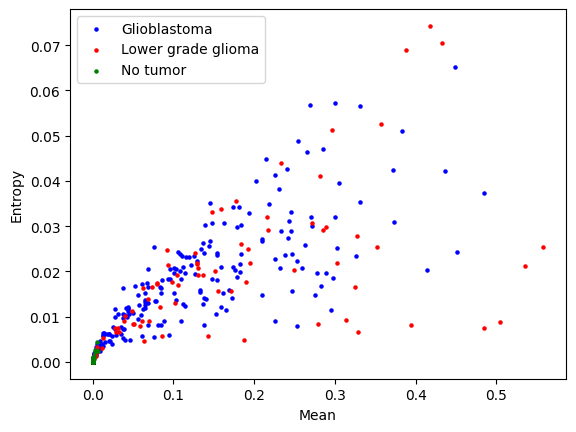

In [30]:
import matplotlib.pyplot as plt
import numpy as np

colors = ['blue', 'red', 'green']

print('hgg', len(entropies_hgg), 'lgg', len(entropies_lgg), 'em', len(entropies_empty))

# for i in range(5):
#     print('e', entropies_hgg[i]*100, entropies_lgg[i]*100, entropies_empty[i]*100)
#     print('m', means_hgg[i]*100, means_lgg[i]*100, means_empty[i]*100)
# before length - hgg 324 lgg 120 em 390
plt.scatter(means_hgg, entropies_hgg, color=colors[0], s=5, label='Glioblastoma')
plt.scatter(means_lgg, entropies_lgg, color=colors[1], s=5, label='Lower grade glioma')
plt.scatter(means_empty, entropies_empty, color=colors[2], s=5, label='No tumor')

plt.xlabel('Mean')
plt.ylabel('Entropy')
# plt.title('Scatter Plot')

plt.legend()
plt.show()

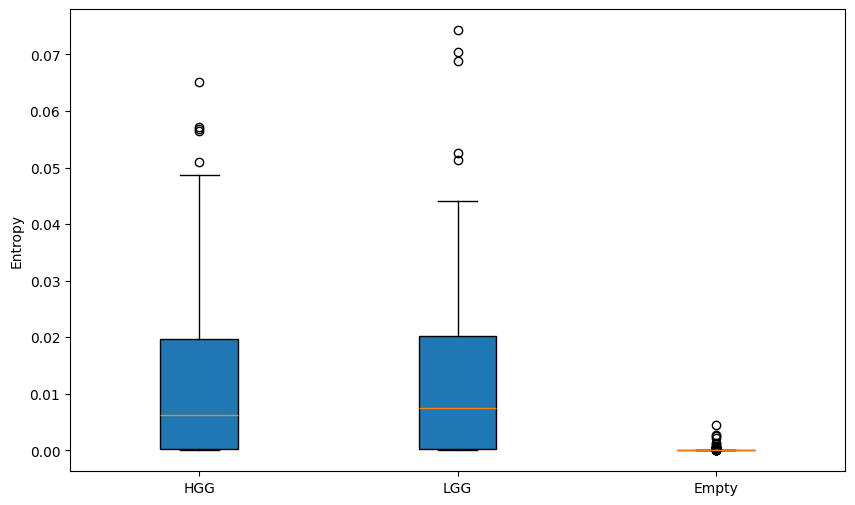

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Combine the arrays into a list
data = [entropies_hgg, entropies_lgg, entropies_empty]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create the boxplot
ax.boxplot(data, patch_artist=True)

# Set the x-tick labels
ax.set_xticklabels(['HGG', 'LGG', 'Empty'])

# Set the title and labels
# ax.set_title('Boxplot of Arrays with Different Lengths')
# ax.set_xlabel('Arrays')
ax.set_ylabel('Entropy')

# Show the plot
plt.show()
